In [1]:
import tracers as tr
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
matched_path = r"mapmatchoutput/matched_BEL-2022-12-25.csv"

#read each line as a list of ints
with open(matched_path) as f:
    matched = [list(map(int, line.split(','))) for line in f]

belgraph = tr.PyGraph()
belgraph.load_graph("/home/toon/Documents/PHD/coding/lifesight/datasets/osmdata/belgium-latest.osm.pbf")

In [26]:
features = [belgraph.extract_mobility_features(matched_trace) for matched_trace in matched[:20]]
#flatten over first dimension
features = [item for sublist in features for item in sublist]

In [27]:
t1 = torch.tensor([[1,2],[11,12]]).float()
t2 = torch.pow(t1, 2)
torch.stack((t1, t2), dim=1).reshape(-1, 4)

tensor([[  1.,   2.,   1.,   4.],
        [ 11.,  12., 121., 144.]])

In [28]:
# flatten features in the first dimension with numpy
features = np.array(features)
print(features.shape)
flat_features = features
X1 = torch.from_numpy(flat_features[:, :2]).float()
X2 = torch.pow(X1, 2) 
#stack
X = torch.stack((X1, X2), dim=1).reshape(-1, 4)

y = torch.from_numpy(flat_features[:, -1]).float()
print(X.shape, y.shape)
y.shape, X

(150474, 3)
torch.Size([150474, 4]) torch.Size([150474])


(torch.Size([150474]),
 tensor([[2.0762e+01, 0.0000e+00, 4.3106e+02, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.0762e+01, 0.0000e+00, 4.3106e+02, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.7550e+02, 0.0000e+00, 3.0799e+04, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]))

In [29]:
# Define a custom model
class CustomModel(nn.Module):
    def __init__(self, input_size):
        super(CustomModel, self).__init__()
        self.layer = nn.Linear(input_size, 2)
        #add nn layer
        self.layer2 = nn.Linear(2, 1)
        # self.softmax = nn.Softmax(dim=1)
        nn.init.xavier_normal_(self.layer.weight)

    def forward(self, x):
        x = self.layer2(self.layer(x))
        # x = self.softmax(x)
        return x
    
input_size = X.shape[1]

model = CustomModel(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y)
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 0: train loss: 96457932800.0
Epoch 1: train loss: 96095887360.0
Epoch 2: train loss: 95734882304.0
Epoch 3: train loss: 95374983168.0
Epoch 4: train loss: 95016173568.0
Epoch 5: train loss: 94658461696.0
Epoch 6: train loss: 94301880320.0
Epoch 7: train loss: 93946462208.0
Epoch 8: train loss: 93592215552.0
Epoch 9: train loss: 93239132160.0
Epoch 10: train loss: 92887236608.0
Epoch 11: train loss: 92536561664.0
Epoch 12: train loss: 92187099136.0
Epoch 13: train loss: 91838873600.0
Epoch 14: train loss: 91491876864.0
Epoch 15: train loss: 91146133504.0
Epoch 16: train loss: 90801651712.0
Epoch 17: train loss: 90458447872.0
Epoch 18: train loss: 90116521984.0
Epoch 19: train loss: 89775865856.0
Epoch 20: train loss: 89436512256.0
Epoch 21: train loss: 89098469376.0
Epoch 22: train loss: 88761712640.0
Epoch 23: train loss: 88426266624.0
Epoch 24: train loss: 88092131328.0
Epoch 25: train loss: 87759331328.0
Epoch 26: train loss: 87427809280.0
Epoch 27: train loss: 87097630720.0
Ep

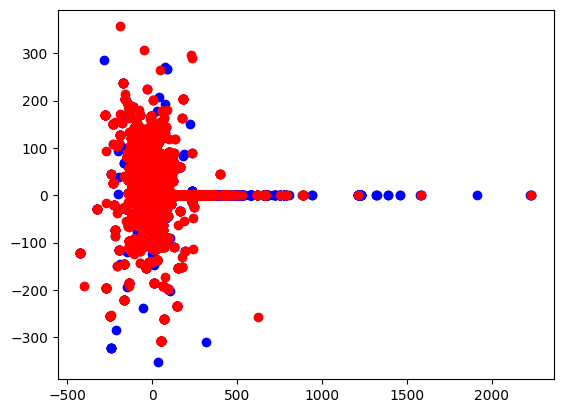

In [30]:
inplot = flat_features
# features on whether the last column is 1 or 0
in1 = inplot[inplot[:, -1] == 1]
in0 = inplot[inplot[:, -1] == 0]
# plot in1 in blue and in0 in red. The first column is the radius, the second the angle
if in1.shape[0] > 0:
    plt.scatter(in1[:, 0] * np.cos(in1[:, 1]), in1[:, 0] * np.sin(in1[:, 1]), c='b')
if in0.shape[0] > 0:
    plt.scatter(in0[:, 0] * np.cos(in0[:, 1]), in0[:, 0] * np.sin(in0[:, 1]), c='r')
plt.show()


In [31]:
# a linspace over the radius from 0 to 1000
xprange = np.linspace(0, 1000, 100)
# a linspace over the angle from -pi to pi
aprange = np.linspace(-np.pi, np.pi, 100)
# meshgrid
xp, ap = np.meshgrid(xprange, aprange)  
#flatten
xp = xp.reshape(-1)
ap = ap.reshape(-1)
# stack
Xp1 = np.stack((xp, ap), axis=1)
# square
Xp2 = np.power(Xp1, 2)
# stack
Xp = np.stack((Xp1, Xp2), axis=1).reshape(-1, 4)
# convert to tensor
Xp = torch.from_numpy(Xp).float()
# predict
yp_pred = model(Xp)
# we now have predictions of (d, alpha)  = y_pred
# integrate over the radius d to show most probable angle
yp_pred = yp_pred.reshape(100, 100)


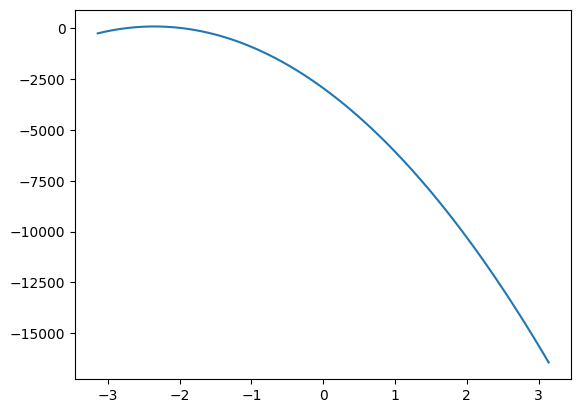

In [32]:
# sum yp_pred over the radius
angle_prob = yp_pred.sum(dim=0)
# list(zip(angle_prob.detach(), aprange))
# plot using the values of ap
plt.plot(aprange, angle_prob.detach().numpy())
plt.show()


In [40]:
X[:,0:2].shape, y.shape

(torch.Size([150474, 2]), torch.Size([150474]))

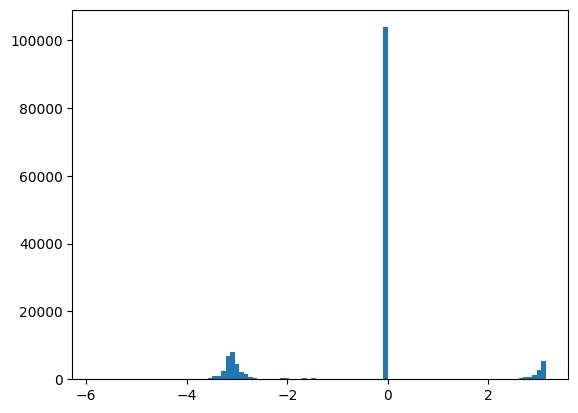

In [54]:
ain = X[:,1]
radians_ain = np.deg2rad(ain)
#histogram of the angle
plt.hist(radians_ain, bins=100)
plt.show()

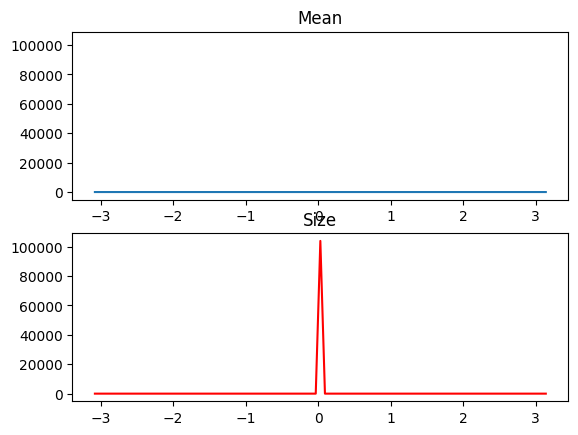

In [50]:
day = np.array([[a, y] for ([d, a], y) in zip(X[:, 0:2], y)])
# make bins form -pi to pi and sum the y values in each bin
bins = np.linspace(-np.pi,  np.pi, 100)
digitized = np.digitize(day[:, 0], bins)
bin_means = [day[:, 1][digitized == i].mean() if len(
    day[:, 1][digitized == i]) > 0 else 0 for i in range(1, len(bins))]
# same but size of bins
bin_sizes = [len(day[:, 1][digitized == i]) for i in range(1, len(bins))]
# set the 0 angle bin to 0
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

ax1.plot(bins[1:], bin_means)
ax1.set_title('Mean')
ax2.plot(bins[1:], bin_sizes, c='r')
ax2.set_title('Size')
plt.show()